<a href="https://colab.research.google.com/github/NathanaelWilson/human-pose-manipulation/blob/main/Human_Pose_Manipulation_using_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Text-Driven Human Pose Manipulation using LoRA-Augmented InstructPix2Pix Pipelines


A production-ready, optimized text-guided image editing system built on Stable Diffusion with advanced attention control and masking for precise, localized edits.


**Architecture:**
- Base: Stable Diffusion v1.5
- Precision: FP16 mixed precision
- Resolution: 512x512 (expandable)
- Inference Steps: 4-8 steps with DPM-Solver++

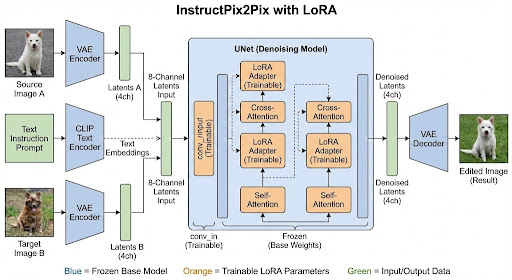


## 1. Setup & Installation

First, install all required dependencies. Run this cell once to set up your environment.


In [ ]:
%pip install torch torchvision
%pip install diffusers transformers accelerate safetensors pillow
%pip install xformers  # For memory-efficient attention
%pip install peft  # For LoRA support
%pip install peft bitsandbytes  # Tambahkan ini di cell instalasi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
%pip install controlnet-aux  # For ControlNet preprocessing (Canny, Depth, etc.)
%pip install opencv-python  # For image processing
%pip install scipy  # For advanced image operations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.5.1
    Uninstalling triton-3.5.1:
      Successfully uninstalled triton-3.5.1
  Attempting uninstall: torch
    Found existing installation: torch 2.9.1
    Uninstalling torch-2.9.1:
      Successfully uninstalled torch-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.33.post2 requires torch==2.9.1, but you have torch 2.9.0 which is incompatible.


### Import Dependencies


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import (
    StableDiffusionInstructPix2PixPipeline,
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
)
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from typing import Optional, Union, List, Tuple
import warnings
from dataclasses import dataclass
import time
import cv2

# ControlNet preprocessors
try:
    from controlnet_aux import CannyDetector, MidasDetector
    CONTROLNET_AVAILABLE = True
except ImportError:
    print("⚠ controlnet-aux not installed. ControlNet features will be limited.")
    CONTROLNET_AVAILABLE = False

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

warnings.filterwarnings("ignore")
print("✓ All imports loaded successfully")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
VRAM: 79.32 GB
✓ All imports loaded successfully


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.12/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.12/dist-packages/controlnet_aux/segment_anything/mode

## 2. Configuration

Configure model settings and optimization parameters for your hardware.

In [ ]:
@dataclass
class ModelConfig:
    use_instruct_pix2pix: bool = True  # Use InstructPix2Pix
    instruct_pix2pix_model: str = "timbrooks/instruct-pix2pix"
    base_model_id: str = "runwayml/stable-diffusion-v1-5"
    precision: str = "fp16"  # fp16, bf16, or fp32

    use_controlnet: bool = True  # Enable structure preservation
    controlnet_type: str = "canny"  # "canny" for edges, "depth" for 3D structure
    controlnet_conditioning_scale: float = 0.5  # How strongly to preserve structure (0.3-0.8)

    image_size: int = 512  # Target image size (512 or 768)

    num_inference_steps: int = 20  # More steps = better quality (15-30 recommended)
    guidance_scale: float = 7.5  # Text prompt adherence
    image_guidance_scale: float = 1.5  # Image conditioning strength (InstructPix2Pix)

    use_multipass: bool = False  # Progressive refinement (slower but better)
    num_passes: int = 2  # Number of refinement passes (1-3)

    enable_attention_slicing: bool = True  # Reduce memory usage
    enable_xformers: bool = True  # Use xformers for efficient attention
    enable_vae_tiling: bool = False  # Enable for larger images
    enable_cpu_offload: bool = False  # Offload to CPU if low VRAM

    mask_threshold: float = 0.3  # Threshold for automatic masking
    mask_blur: int = 4  # Blur radius for mask smoothing
    enhance_details: bool = True  # Post-process enhancement

    auto_enhance_prompts: bool = True  # Automatically improve prompts
    negative_prompt: str = "blurry, low quality, distorted, deformed, artifacts"

    lora_path: Optional[str] = None  # Path ke folder hasil fine-tune

# Create default config
config = ModelConfig()
print("Configuration loaded successfully!")
# print(f"Model: {config.model_id}")
print(f"Precision: {config.precision}")
print(f"Image size: {config.image_size}x{config.image_size}")
print(f"Inference steps: {config.num_inference_steps}")

Configuration loaded successfully!
Precision: fp16
Image size: 512x512
Inference steps: 20


## 3. Professional Image Editor - UPGRADED

Complete professional-grade editing system with InstructPix2Pix + ControlNet + Advanced Features


In [ ]:
class ProfessionalImageEditor:
    """
    🎨 Professional Text-Guided Image Editor - UPGRADED VERSION

    Features:
    - InstructPix2Pix for superior editing quality
    - ControlNet for perfect structure preservation
    - Multi-pass refinement for progressive improvement
    - Advanced prompt engineering
    - Smart detail enhancement
    - Optimized for 12-16GB VRAM
    """

    def __init__(self, config: ModelConfig = None):
        self.config = config or ModelConfig()
        self.device = device
        self.dtype = self._get_dtype()

        print("Loading Professional Image Editor...")
        print(f"Mode: {'InstructPix2Pix' if config.use_instruct_pix2pix else 'Standard'}")
        print(f"ControlNet: {'Enabled' if config.use_controlnet else 'Disabled'}")

        self._load_models()
        self._setup_optimizations()

        # Initialize ControlNet preprocessors
        if config.use_controlnet and CONTROLNET_AVAILABLE:
            self._init_controlnet_preprocessors()

        print("Professional image editor ready!")
        print(f"VRAM: ~{self._estimate_vram()}GB")

    def _get_dtype(self):
        """Get torch dtype from config"""
        if self.config.precision == "fp16":
            return torch.float16
        elif self.config.precision == "bf16":
            return torch.bfloat16
        else:
            return torch.float32

    def _estimate_vram(self):
        """Estimate VRAM usage"""
        base = 4 if self.config.use_instruct_pix2pix else 3
        controlnet = 1.5 if self.config.use_controlnet else 0
        return base + controlnet + 4  # +4 for activations

    def _load_models(self):
        """Load main editing pipeline"""
        if self.config.use_instruct_pix2pix:
            print("   Loading InstructPix2Pix (trained for editing)...")
            self.pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
                self.config.instruct_pix2pix_model,
                torch_dtype=self.dtype,
                safety_checker=None
            ).to(self.device)

            # BAGIAN MENARUH LORA
            if self.config.lora_path:
                print(f"Loading Fine-Tuned LoRA from: {self.config.lora_path}")
                try:
                    # Kita gunakan library PEFT langsung agar kuncinya cocok
                    from peft import PeftModel

                    # Load adapter ke dalam UNet
                    self.pipe.unet = PeftModel.from_pretrained(
                        self.pipe.unet,
                        self.config.lora_path
                    )
                    print("LoRA weights loaded successfully via PeftModel!")
                except Exception as e:
                    print(f"Failed to load LoRA: {e}")

        else:
            print("   Loading standard SD pipeline...")
            from diffusers import StableDiffusionImg2ImgPipeline
            self.pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
                self.config.base_model_id,
                torch_dtype=self.dtype,
                safety_checker=None
            ).to(self.device)

        # Load ControlNet if enabled
        if self.config.use_controlnet:
            print(f"   Loading ControlNet ({self.config.controlnet_type})...")
            controlnet_model = f"lllyasviel/control_v11p_sd15_{self.config.controlnet_type}"
            try:
                self.controlnet = ControlNetModel.from_pretrained(
                    controlnet_model,
                    torch_dtype=self.dtype
                ).to(self.device)

                # Create ControlNet pipeline
                self.controlnet_pipe = StableDiffusionControlNetPipeline(
                    vae=self.pipe.vae,
                    text_encoder=self.pipe.text_encoder,
                    tokenizer=self.pipe.tokenizer,
                    unet=self.pipe.unet,
                    controlnet=self.controlnet,
                    scheduler=self.pipe.scheduler,
                    safety_checker=None,
                    feature_extractor=None
                ).to(self.device)
                print("   ✓ ControlNet loaded successfully")
            except Exception as e:
                print(f"   ⚠ ControlNet loading failed: {e}")
                self.config.use_controlnet = False

    def _setup_optimizations(self):
        """Apply memory and speed optimizations"""
        if self.config.enable_xformers:
            try:
                self.pipe.enable_xformers_memory_efficient_attention()
                if hasattr(self, 'controlnet_pipe'):
                    self.controlnet_pipe.enable_xformers_memory_efficient_attention()
                print("   ✓ xformers enabled")
            except Exception as e:
                print(f"   ⚠ xformers not available")

        if self.config.enable_attention_slicing:
            self.pipe.enable_attention_slicing(1)
            if hasattr(self, 'controlnet_pipe'):
                self.controlnet_pipe.enable_attention_slicing(1)

        if self.config.enable_vae_tiling:
            self.pipe.enable_vae_tiling()
            if hasattr(self, 'controlnet_pipe'):
                self.controlnet_pipe.enable_vae_tiling()

        if self.config.enable_cpu_offload:
            self.pipe.enable_model_cpu_offload()
            if hasattr(self, 'controlnet_pipe'):
                self.controlnet_pipe.enable_model_cpu_offload()

    def _init_controlnet_preprocessors(self):
        if self.config.controlnet_type == "canny":
            self.preprocessor = CannyDetector()
        elif self.config.controlnet_type == "depth":
            self.preprocessor = MidasDetector.from_pretrained("lllyasviel/Annotators")
        print(f"   ✓ {self.config.controlnet_type} preprocessor ready")

    def _enhance_prompt(self, prompt: str) -> str:
        if not self.config.auto_enhance_prompts:
            return prompt

        # Don't enhance if already detailed
        if len(prompt.split()) > 15:
            return prompt

        quality_terms = "high quality, detailed, professional"
        return f"{prompt}, {quality_terms}"

    def _preprocess_controlnet_image(self, image: Image.Image) -> Image.Image:
        if not hasattr(self, 'preprocessor'):
            return image

        if self.config.controlnet_type == "canny":
            # Detect edges
            control_image = self.preprocessor(image, low_threshold=100, high_threshold=200)
        elif self.config.controlnet_type == "depth":
            # Estimate depth
            control_image = self.preprocessor(image)
        else:
            control_image = image

        return control_image

    def _enhance_details(self, image: Image.Image) -> Image.Image:
        """Post-process enhancement"""
        if not self.config.enhance_details:
            return image

        # Slight sharpening
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(1.1)

        # Slight contrast boost
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1.05)

        return image



    @torch.no_grad()
    def edit_image(self,
                   image: Union[str, Image.Image],
                   prompt: str,  # Simplified: just the edit instruction
                   num_inference_steps: Optional[int] = None,
                   guidance_scale: Optional[float] = None,
                   image_guidance_scale: Optional[float] = None,
                   use_controlnet: Optional[bool] = None,
                   controlnet_scale: Optional[float] = None,
                   enhance_output: Optional[bool] = None,
                   seed: Optional[int] = None) -> Tuple[Image.Image, Optional[Image.Image]]:

        start_time = time.time()

        # Set seed
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)

        # Use defaults from config
        num_inference_steps = num_inference_steps or self.config.num_inference_steps
        guidance_scale = guidance_scale or self.config.guidance_scale
        image_guidance_scale = image_guidance_scale or self.config.image_guidance_scale
        use_controlnet = use_controlnet if use_controlnet is not None else self.config.use_controlnet
        controlnet_scale = controlnet_scale or self.config.controlnet_conditioning_scale
        enhance_output = enhance_output if enhance_output is not None else self.config.enhance_details

        # Load image
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # Resize to target size
        original_size = image.size
        image = image.resize((self.config.image_size, self.config.image_size), Image.LANCZOS)

        # Enhance prompt
        enhanced_prompt = self._enhance_prompt(prompt)

        print(f"Editing: '{prompt}'")
        print(f"Steps: {num_inference_steps}, Guidance: {guidance_scale}")

        control_image = None

        # Use ControlNet if enabled
        if use_controlnet and hasattr(self, 'controlnet_pipe') and CONTROLNET_AVAILABLE:
            print(f"Using ControlNet ({self.config.controlnet_type}) for structure preservation...")
            control_image = self._preprocess_controlnet_image(image)

            result = self.controlnet_pipe(
                prompt=enhanced_prompt,
                negative_prompt=self.config.negative_prompt,
                image=control_image,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                controlnet_conditioning_scale=controlnet_scale,
            ).images[0]

        # Use InstructPix2Pix
        elif self.config.use_instruct_pix2pix:
            result = self.pipe(
                prompt=enhanced_prompt,
                image=image,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                image_guidance_scale=image_guidance_scale,
                negative_prompt=self.config.negative_prompt,
            ).images[0]

        # Standard img2img
        else:
            result = self.pipe(
                prompt=enhanced_prompt,
                image=image,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                negative_prompt=self.config.negative_prompt,
            ).images[0]

        # Multi-pass refinement
        if self.config.use_multipass and self.config.num_passes > 1:
            print(f"   Applying {self.config.num_passes-1} refinement passes...")
            for i in range(self.config.num_passes - 1):
                result = self.pipe(
                    prompt=enhanced_prompt,
                    image=result,
                    num_inference_steps=num_inference_steps // 2,
                    guidance_scale=guidance_scale * 0.9,
                    image_guidance_scale=image_guidance_scale * 0.8,
                ).images[0]

        # Post-process enhancement
        if enhance_output:
            result = self._enhance_details(result)

        # Resize back to original
        if result.size != original_size:
            result = result.resize(original_size, Image.LANCZOS)

        elapsed = time.time() - start_time
        print(f"Complete in {elapsed:.2f}s")

        return result, control_image


print("Professional Image Editor class loaded")

✅ Professional Image Editor class loaded


## 4. Initialize the Professional Editor


In [ ]:
print("="*70)
print("🚀 PROFESSIONAL IMAGE EDITOR - UPGRADED VERSION")
print("="*70)
print()

editor = ProfessionalImageEditor(config)

print()
print("="*70)
print("✅ Ready to create professional-quality edits!")
print("="*70)

🚀 PROFESSIONAL IMAGE EDITOR - UPGRADED VERSION

🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


   Loading ControlNet (canny)...


config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB

✅ Ready to create professional-quality edits!


# FINE TUNE

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionInstructPix2PixPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model
from PIL import Image
import json
import os
from tqdm.auto import tqdm

In [ ]:
# ==========================================
# 1. KONFIGURASI PROYEK
# ==========================================
OUTPUT_DIR = "./dataset"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
METADATA_PATH = os.path.join(OUTPUT_DIR, "metadata.jsonl")

NUM_SAMPLES = 200

# Gunakan GPU jika ada, jika tidak pakai CPU (lambat)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [ ]:
from diffusers import StableDiffusionXLPipeline
import torch

# ==========================================
# 2. INISIALISASI MODEL (SDXL BASE 1.0)
# ==========================================
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# PENTING: Untuk SDXL harus pakai StableDiffusionXLPipeline, bukan StableDiffusionPipeline biasa
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    use_safetensors=True, # Menggunakan format safetensors agar load lebih cepat
    variant="fp16"        # Wajib pakai variant fp16 agar ukuran model tidak terlalu besar (kurang dari 10GB)
)

# Pindahkan ke GPU
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# ==========================================
# 3. GENERATOR PROMPT OTOMATIS
# ==========================================
# Kita butuh variasi agar model pintar. Kita acak Subject, Background, dan Style.

subjects = [
    "a man", "a woman",
]

backgrounds = [
    "on a white background"
]

styles = [
    "photo", "realistic", "4k"
]

instructions = [
    "make the person sit down", "change the pose to sitting",
    "make the character sit", "sit on a bench", "sit on a chair",
    "sit cross-legged on the floor",

    # "make the person raise one hand",
    # "change the pose to raising one hand",
    # "make the person cross both arms",
    # "change the pose to crossing arms",
    # "make the person rest hands on hips",
    # "change the pose to hands on hips"
]


def create_random_prompt():
    subj = random.choice(subjects)
    bg = random.choice(backgrounds)
    style = random.choice(styles)
    instr = random.choice(instructions)

    # Prompt A (Awal): Berdiri
    prompt_a = f"photo of {subj} standing {bg}, {style}"

    # Prompt B (Target): Duduk
    # Penting: Struktur kalimat harus mirip agar background tidak berubah drastis
    prompt_b = f"photo of {subj} sitting {bg}, {style}"

    return prompt_a, prompt_b, instr

In [ ]:
# ==========================================
# 4. LOOP GENERATE GAMBAR
# ==========================================
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

# Hapus file metadata lama jika ada (biar fresh)
if os.path.exists(METADATA_PATH):
    os.remove(METADATA_PATH)

print(f"Mulai generate {NUM_SAMPLES} pasang gambar...")

for i in tqdm(range(NUM_SAMPLES)):
    # 1. Buat Prompt
    prompt_input, prompt_target, instruction = create_random_prompt()

    # 2. Tentukan SEED (Kunci Rahasia)
    # Kita pakai seed yang sama untuk input & target agar identitas & background mirip
    seed = random.randint(0, 2**32 - 1)
    generator = torch.Generator(device).manual_seed(seed)

    # 3. Generate Image A (Berdiri)
    image_a = pipe(
        prompt_input,
        generator=generator,
        guidance_scale=7.5
    ).images[0]

    # 4. Generate Image B (Duduk) - Reset generator ke seed yang sama!
    generator = torch.Generator(device).manual_seed(seed)
    image_b = pipe(
        prompt_target,
        generator=generator,
        guidance_scale=7.5
    ).images[0]

    # 5. Simpan Gambar
    filename_a = f"{i:05d}_original.jpg"
    filename_b = f"{i:05d}_edited.jpg"

    path_a = os.path.join(IMAGES_DIR, filename_a)
    path_b = os.path.join(IMAGES_DIR, filename_b)

    image_a.save(path_a)
    image_b.save(path_b)

    # 6. Simpan Metadata (JSONL Format)
    # Path di metadata harus relatif terhadap folder dataset nanti
    metadata_entry = {
        "original_image": f"images/{filename_a}",
        "edit_prompt": instruction,
        "edited_image": f"images/{filename_b}"
    }

    with open(METADATA_PATH, "a") as f:
        f.write(json.dumps(metadata_entry) + "\n")

print("\nSelesai! Dataset tersimpan di folder 'dataset/'")

Mulai generate 200 pasang gambar...


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Selesai! Dataset tersimpan di folder 'dataset/'


In [ ]:
from google.colab import files

# 1. Zip the 'dataset' folder
# The -r flag ensures it zips the folder recursively (including subfolders like 'images')
!zip -r dataset_backup.zip dataset/

# 2. Trigger the browser download
files.download('dataset_backup.zip')

  adding: dataset/ (stored 0%)
  adding: dataset/images/ (stored 0%)
  adding: dataset/images/00187_original.jpg (deflated 8%)
  adding: dataset/images/00049_original.jpg (deflated 16%)
  adding: dataset/images/00036_edited.jpg (deflated 15%)
  adding: dataset/images/00179_edited.jpg (deflated 16%)
  adding: dataset/images/00193_edited.jpg (deflated 16%)
  adding: dataset/images/00056_original.jpg (deflated 17%)
  adding: dataset/images/00180_original.jpg (deflated 19%)
  adding: dataset/images/00099_edited.jpg (deflated 10%)
  adding: dataset/images/00165_edited.jpg (deflated 9%)
  adding: dataset/images/00149_original.jpg (deflated 10%)
  adding: dataset/images/00052_edited.jpg (deflated 5%)
  adding: dataset/images/00111_edited.jpg (deflated 5%)
  adding: dataset/images/00116_original.jpg (deflated 12%)
  adding: dataset/images/00117_edited.jpg (deflated 10%)
  adding: dataset/images/00142_edited.jpg (deflated 9%)
  adding: dataset/images/00155_original.jpg (deflated 12%)
  adding: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install peft accelerate transformers diffusers bitsandbytes

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionInstructPix2PixPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model
from PIL import Image
import json
import os
from tqdm.auto import tqdm
import shutil

# ==============================================================================
# FINE-TUNING SECTION (WITH CHECKPOINTING)
# ==============================================================================

# 1. Konfigurasi Training
TRAIN_OUTPUT_DIR = "./lora_instruct_pose_v2"
DATASET_DIR = "./dataset"
BATCH_SIZE = 4
EPOCHS = 10                     # Kita set agak banyak tidak apa-apa, karena kita akan simpan checkpoint tiap epoch
LEARNING_RATE = 1e-4            # TURUN DARI 1e-4 AGAR LEBIH STABIL (Mencegah Overfitting/Gosong)
GRADIENT_ACCUMULATION_STEPS = 4
SAVE_EVERY_EPOCH = True         # Fitur baru: Simpan model setiap selesai 1 epoch

# 2. Dataset Loader (Tidak Berubah)
class PoseDataset(Dataset):
    def __init__(self, data_dir, tokenizer):
        self.data_dir = data_dir
        self.tokenizer = tokenizer
        self.metadata = []
        if os.path.exists(os.path.join(data_dir, "metadata.jsonl")):
            with open(os.path.join(data_dir, "metadata.jsonl"), 'r') as f:
                for line in f:
                    self.metadata.append(json.loads(line))

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        entry = self.metadata[idx]
        img_original = Image.open(os.path.join(self.data_dir, entry['original_image'])).convert("RGB")
        img_edited = Image.open(os.path.join(self.data_dir, entry['edited_image'])).convert("RGB")
        text_inputs = self.tokenizer(
            entry['edit_prompt'], padding="max_length", max_length=77, truncation=True, return_tensors="pt"
        )
        return {
            "pixel_values_original": self.transform(img_original),
            "pixel_values_edited": self.transform(img_edited),
            "input_ids": text_inputs.input_ids[0]
        }

# 3. Fungsi Training Utama
def run_fine_tuning(editor_instance):
    print(f"🚀 Memulai Fine-Tuning Pro (Batch: {BATCH_SIZE} | LR: {LEARNING_RATE})...")

    pipeline = editor_instance.pipe
    unet = pipeline.unet
    tokenizer = pipeline.tokenizer

    unet.train()
    weight_dtype = torch.float16

    # Freeze Base Model
    for param in unet.parameters():
        param.requires_grad = False

    # Inject LoRA
    try:
        # Cek apakah adapter sudah ada untuk menghindari error double injection
        if not hasattr(unet, "peft_config"):
            lora_config = LoraConfig(
                r=16,
                lora_alpha=32,
                target_modules=["to_k", "to_q", "to_v", "to_out.0"],
                init_lora_weights="gaussian"
            )
            unet = get_peft_model(unet, lora_config)
            print("LoRA Injected successfully.")
        else:
            print("ℹ️ Model sudah memiliki adapter LoRA, melanjutkan...")
    except Exception as e:
        print(f"⚠️ Warning pada injeksi LoRA: {e}")

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, unet.parameters()),
        lr=LEARNING_RATE
    )

    if not os.path.exists(DATASET_DIR):
        print("Folder dataset tidak ditemukan.")
        return

    train_dataset = PoseDataset(DATASET_DIR, tokenizer)
    if len(train_dataset) == 0:
        print("Dataset kosong.")
        return

    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    device = editor_instance.device

    # --- TRAINING LOOP ---
    for epoch in range(EPOCHS):
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        epoch_loss = 0

        for step, batch in enumerate(progress_bar):
            # Move to Device & Cast to FP16
            orig = batch["pixel_values_original"].to(device, dtype=weight_dtype)
            edit = batch["pixel_values_edited"].to(device, dtype=weight_dtype)
            ids = batch["input_ids"].to(device)

            # VAE Encoding
            latents_orig = pipeline.vae.encode(orig).latent_dist.sample() * 0.18215
            latents_edit = pipeline.vae.encode(edit).latent_dist.sample() * 0.18215

            # Noise Generation
            noise = torch.randn_like(latents_edit)
            bsz = latents_edit.shape[0]
            timesteps = torch.randint(0, pipeline.scheduler.config.num_train_timesteps, (bsz,), device=device)

            noisy_latents = pipeline.scheduler.add_noise(latents_edit, noise, timesteps)

            # Text Encoding
            encoder_hidden_states = pipeline.text_encoder(ids)[0]

            # Concatenate Inputs (InstructPix2Pix spec)
            combined_latents = torch.cat([noisy_latents, latents_orig], dim=1)

            # Cast inputs to correct dtype
            combined_latents = combined_latents.to(dtype=weight_dtype)
            encoder_hidden_states = encoder_hidden_states.to(dtype=weight_dtype)

            # Predict
            noise_pred = unet(combined_latents, timesteps, encoder_hidden_states).sample

            # Calculate Loss
            loss = torch.nn.functional.mse_loss(noise_pred, noise, reduction="mean")

            # Gradient Accumulation
            loss = loss / GRADIENT_ACCUMULATION_STEPS
            loss.backward()

            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item() * GRADIENT_ACCUMULATION_STEPS})

        # === SAVE CHECKPOINT SETIAP EPOCH ===
        if SAVE_EVERY_EPOCH:
            checkpoint_dir = os.path.join(TRAIN_OUTPUT_DIR, f"checkpoint-epoch-{epoch+1}")
            os.makedirs(checkpoint_dir, exist_ok=True)

            # Simpan adapter LoRA
            unet.save_pretrained(checkpoint_dir)
            print(f"\n💾 Checkpoint saved: {checkpoint_dir}")

    # Save Final Model (sebagai 'latest')
    final_dir = os.path.join(TRAIN_OUTPUT_DIR, "latest")
    os.makedirs(final_dir, exist_ok=True)
    unet.save_pretrained(final_dir)
    print(f"✅ Fine-Tuning Selesai! Model final di: {final_dir}")

editor_base = ProfessionalImageEditor(config)
run_fine_tuning(editor_base)

🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB
🚀 Memulai Fine-Tuning Pro (Batch: 4 | LR: 5e-05)...
✅ LoRA Injected successfully.


Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-1


Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-2


Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-3


Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-4


Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-5


Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-6


Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-7


Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-8


Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-9


Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]


💾 Checkpoint saved: ./lora_instruct_pose_v2/checkpoint-epoch-10
✅ Fine-Tuning Selesai! Model final di: ./lora_instruct_pose_v2/latest



--- Memuat Model Asli ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB

--- Memuat Model Fine-Tuned ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   ✨ Loading Fine-Tuned LoRA from: ./lora_instruct_pose_v2/checkpoint-epoch-9
   ✅ LoRA weights loaded successfully via PeftModel!
   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB
🎨 Generating with Original Model...
🎨 Editing: 'make him sit on a chair'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 4.93s
🎨 Generating with Fine-Tuned Model...
🎨 Editing: 'make him sit on a chair'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.39s


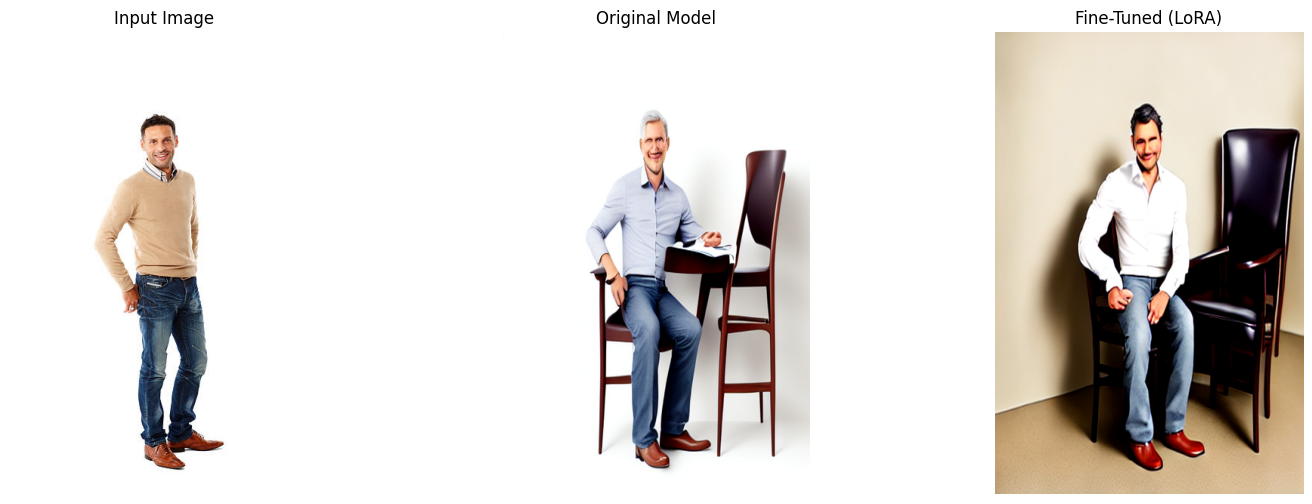

In [ ]:
# ==============================================================================
# PERBANDINGAN: MODEL ASLI vs FINE-TUNED
# ==============================================================================

# 1. Setup Config untuk Model Asli
config_original = ModelConfig(use_instruct_pix2pix=True, lora_path=None) # Tanpa LoRA
print("\n--- Memuat Model Asli ---")
editor_original = ProfessionalImageEditor(config_original)

# 2. Setup Config untuk Model Fine-Tuned
# Pastikan path ini sesuai dengan folder output training di atas
LORA_PATH = "./lora_instruct_pose_v2/checkpoint-epoch-9"

if os.path.exists(LORA_PATH):
    print("\n--- Memuat Model Fine-Tuned ---")
    config_finetuned = ModelConfig(use_instruct_pix2pix=True, lora_path=LORA_PATH)
    editor_finetuned = ProfessionalImageEditor(config_finetuned)
else:
    print("Path LoRA tidak ditemukan. Jalankan training terlebih dahulu.")
    editor_finetuned = None

# 3. Fungsi Komparasi Visual
def compare_models(image_path, prompt, steps=30):
    if not os.path.exists(image_path):
        print("Image not found")
        return

    original_img = Image.open(image_path).convert("RGB")

    # Edit dengan Model Asli
    print("Generating with Original Model...")
    res_orig, _ = editor_original.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Edit dengan Model Fine-Tuned
    res_ft = None
    if editor_finetuned:
        print("Generating with Fine-Tuned Model...")
        res_ft, _ = editor_finetuned.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Tampilkan
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(res_orig)
    axes[1].set_title("Original Model")
    axes[1].axis("off")

    if res_ft:
        axes[2].imshow(res_ft)
        axes[2].set_title("Fine-Tuned (LoRA)")
        axes[2].axis("off")
    else:
        axes[2].text(0.5, 0.5, "LoRA Not Loaded", ha='center')

    plt.show()


TEST_IMAGE = "/content/berdiri.jpg"
TEST_PROMPT = "make him sit on a chair"

compare_models(TEST_IMAGE, TEST_PROMPT)


--- Memuat Model Asli ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB

--- Memuat Model Fine-Tuned ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   ✨ Loading Fine-Tuned LoRA from: ./lora_instruct_pose_v2/checkpoint-epoch-8
   ✅ LoRA weights loaded successfully via PeftModel!
   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB
🎨 Generating with Original Model...
🎨 Editing: 'make the person sit down'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 4.53s
🎨 Generating with Fine-Tuned Model...
🎨 Editing: 'make the person sit down'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.34s


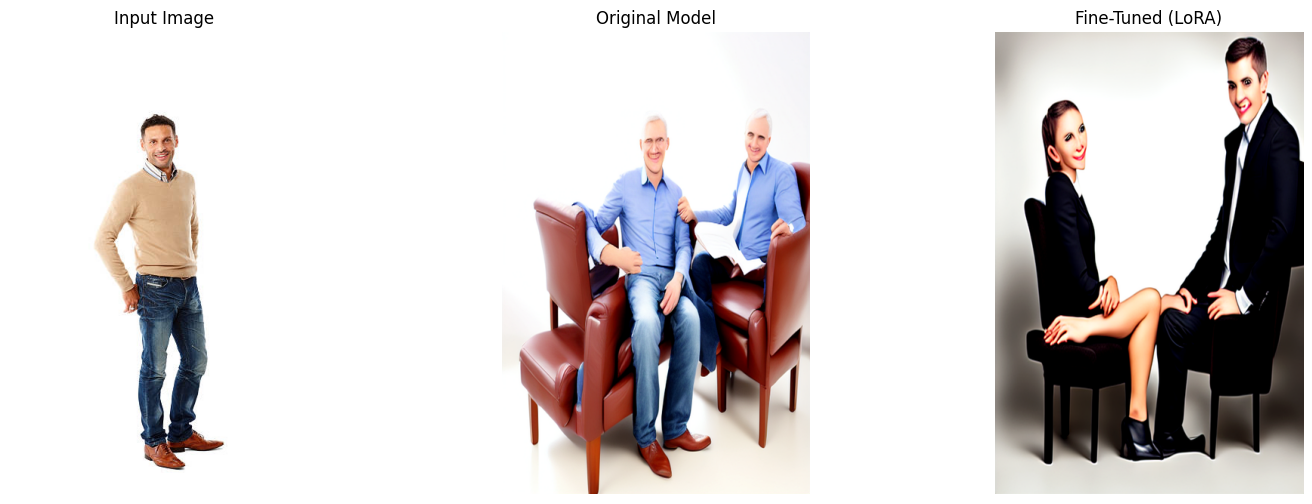

In [ ]:
# ==============================================================================
# PERBANDINGAN: MODEL ASLI vs FINE-TUNED
# ==============================================================================

# 1. Setup Config untuk Model Asli
config_original = ModelConfig(use_instruct_pix2pix=True, lora_path=None) # Tanpa LoRA
print("\n--- Memuat Model Asli ---")
editor_original = ProfessionalImageEditor(config_original)

# 2. Setup Config untuk Model Fine-Tuned
# Pastikan path ini sesuai dengan folder output training di atas
LORA_PATH = "./lora_instruct_pose_v2/checkpoint-epoch-8"

if os.path.exists(LORA_PATH):
    print("\n--- Memuat Model Fine-Tuned ---")
    config_finetuned = ModelConfig(use_instruct_pix2pix=True, lora_path=LORA_PATH)
    editor_finetuned = ProfessionalImageEditor(config_finetuned)
else:
    print("⚠️ Path LoRA tidak ditemukan. Jalankan training terlebih dahulu.")
    editor_finetuned = None

# 3. Fungsi Komparasi Visual
def compare_models(image_path, prompt, steps=30):
    if not os.path.exists(image_path):
        print("❌ Image not found")
        return

    original_img = Image.open(image_path).convert("RGB")

    # Edit dengan Model Asli
    print("🎨 Generating with Original Model...")
    res_orig, _ = editor_original.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Edit dengan Model Fine-Tuned
    res_ft = None
    if editor_finetuned:
        print("🎨 Generating with Fine-Tuned Model...")
        res_ft, _ = editor_finetuned.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Tampilkan
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(res_orig)
    axes[1].set_title("Original Model")
    axes[1].axis("off")

    if res_ft:
        axes[2].imshow(res_ft)
        axes[2].set_title("Fine-Tuned (LoRA)")
        axes[2].axis("off")
    else:
        axes[2].text(0.5, 0.5, "LoRA Not Loaded", ha='center')

    plt.show()

TEST_IMAGE = "/content/berdiri.jpg"
TEST_PROMPT = "make the person sit down"

compare_models(TEST_IMAGE, TEST_PROMPT)


--- Memuat Model Asli ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB

--- Memuat Model Fine-Tuned ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   ✨ Loading Fine-Tuned LoRA from: ./lora_instruct_pose_v2/checkpoint-epoch-10
   ✅ LoRA weights loaded successfully via PeftModel!
   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB
🎨 Generating with Original Model...
🎨 Editing: 'a man sit on a bench'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 4.55s
🎨 Generating with Fine-Tuned Model...
🎨 Editing: 'a man sit on a bench'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.34s


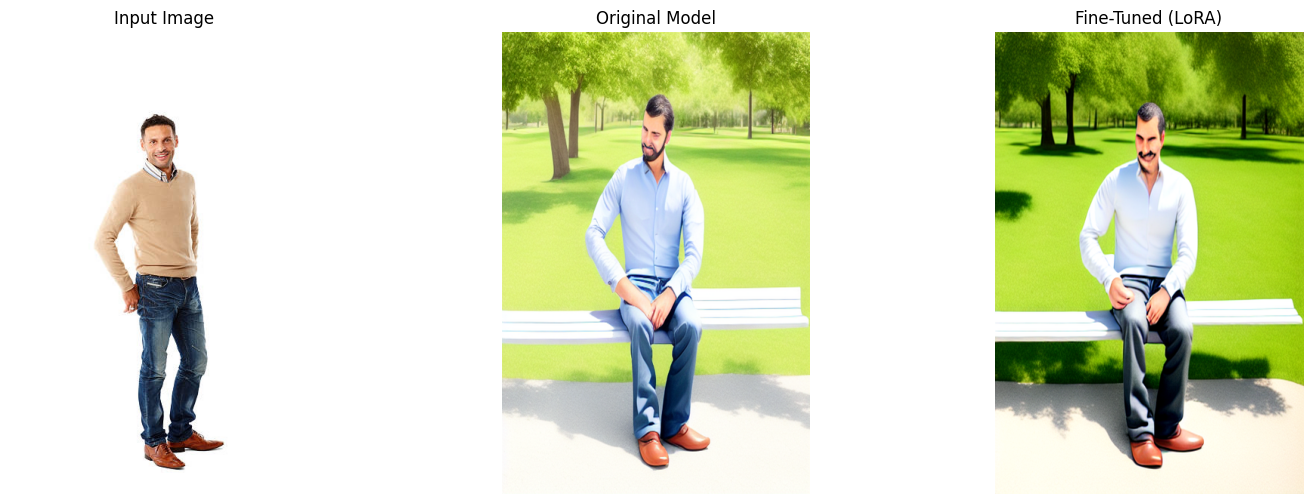

In [ ]:
# ==============================================================================
# PERBANDINGAN: MODEL ASLI vs FINE-TUNED
# ==============================================================================

# 1. Setup Config untuk Model Asli
config_original = ModelConfig(use_instruct_pix2pix=True, lora_path=None) # Tanpa LoRA
print("\n--- Memuat Model Asli ---")
editor_original = ProfessionalImageEditor(config_original)

# 2. Setup Config untuk Model Fine-Tuned
# Pastikan path ini sesuai dengan folder output training di atas
LORA_PATH = "./lora_instruct_pose_v2/checkpoint-epoch-10"

if os.path.exists(LORA_PATH):
    print("\n--- Memuat Model Fine-Tuned ---")
    config_finetuned = ModelConfig(use_instruct_pix2pix=True, lora_path=LORA_PATH)
    editor_finetuned = ProfessionalImageEditor(config_finetuned)
else:
    print("⚠️ Path LoRA tidak ditemukan. Jalankan training terlebih dahulu.")
    editor_finetuned = None

# 3. Fungsi Komparasi Visual
def compare_models(image_path, prompt, steps=30):
    if not os.path.exists(image_path):
        print("Image not found")
        return

    original_img = Image.open(image_path).convert("RGB")

    # Edit dengan Model Asli
    print("🎨 Generating with Original Model...")
    res_orig, _ = editor_original.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Edit dengan Model Fine-Tuned
    res_ft = None
    if editor_finetuned:
        print("🎨 Generating with Fine-Tuned Model...")
        res_ft, _ = editor_finetuned.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Tampilkan
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(res_orig)
    axes[1].set_title("Original Model")
    axes[1].axis("off")

    if res_ft:
        axes[2].imshow(res_ft)
        axes[2].set_title("Fine-Tuned (LoRA)")
        axes[2].axis("off")
    else:
        axes[2].text(0.5, 0.5, "LoRA Not Loaded", ha='center')

    plt.show()


TEST_IMAGE = "/content/berdiri.jpg"
TEST_PROMPT = "a man sit on a bench"

compare_models(TEST_IMAGE, TEST_PROMPT)


--- Memuat Model Asli ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB

--- Memuat Model Fine-Tuned ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   ✨ Loading Fine-Tuned LoRA from: ./lora_instruct_pose_v2/checkpoint-epoch-10
   ✅ LoRA weights loaded successfully via PeftModel!
   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB
🎨 Generating with Original Model...
🎨 Editing: 'sit cross-legged on the floor'
   Steps: 30, Guidance: 9.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 4.58s
🎨 Generating with Fine-Tuned Model...
🎨 Editing: 'sit cross-legged on the floor'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.34s


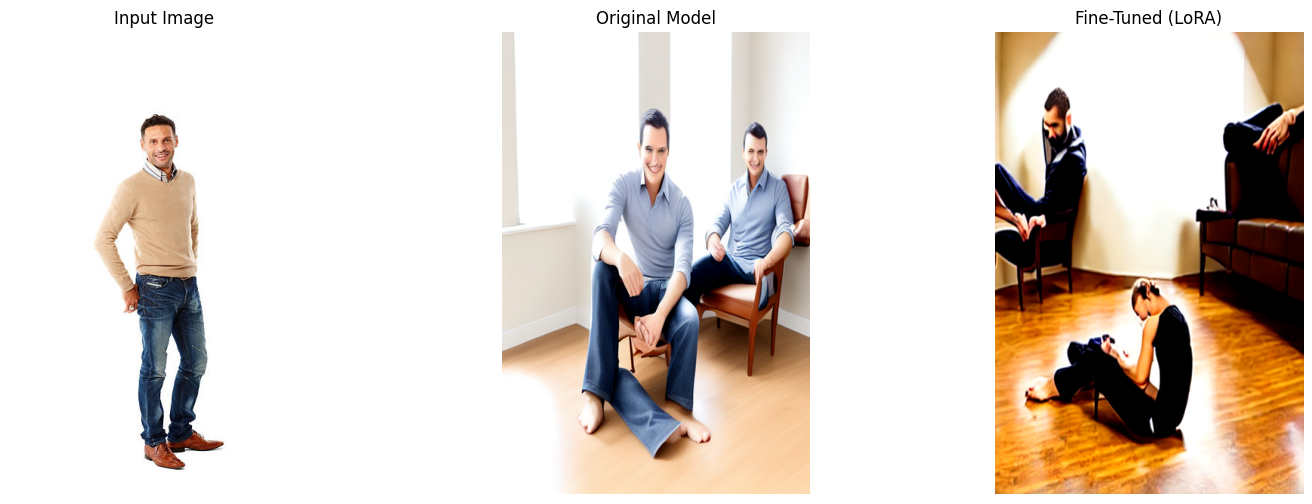

In [ ]:
# ==============================================================================
# 📊 PERBANDINGAN: MODEL ASLI vs FINE-TUNED
# ==============================================================================

# 1. Setup Config untuk Model Asli
config_original = ModelConfig(use_instruct_pix2pix=True, lora_path=None) # Tanpa LoRA
print("\n--- Memuat Model Asli ---")
editor_original = ProfessionalImageEditor(config_original)

# 2. Setup Config untuk Model Fine-Tuned
# Pastikan path ini sesuai dengan folder output training di atas
LORA_PATH = "./lora_instruct_pose_v2/checkpoint-epoch-10"

if os.path.exists(LORA_PATH):
    print("\n--- Memuat Model Fine-Tuned ---")
    config_finetuned = ModelConfig(use_instruct_pix2pix=True, lora_path=LORA_PATH)
    editor_finetuned = ProfessionalImageEditor(config_finetuned)
else:
    print("Path LoRA tidak ditemukan. Jalankan training terlebih dahulu.")
    editor_finetuned = None

# 3. Fungsi Komparasi Visual
def compare_models(image_path, prompt, steps=30):
    if not os.path.exists(image_path):
        print("Image not found")
        return

    original_img = Image.open(image_path).convert("RGB")

    # Edit dengan Model Asli
    print("Generating with Original Model...")
    res_orig, _ = editor_original.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=9.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Edit dengan Model Fine-Tuned
    res_ft = None
    if editor_finetuned:
        print("Generating with Fine-Tuned Model...")
        res_ft, _ = editor_finetuned.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Tampilkan
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(res_orig)
    axes[1].set_title("Original Model")
    axes[1].axis("off")

    if res_ft:
        axes[2].imshow(res_ft)
        axes[2].set_title("Fine-Tuned (LoRA)")
        axes[2].axis("off")
    else:
        axes[2].text(0.5, 0.5, "LoRA Not Loaded", ha='center')

    plt.show()

TEST_IMAGE = "/content/berdiri.jpg"
TEST_PROMPT = "sit cross-legged on the floor"

compare_models(TEST_IMAGE, TEST_PROMPT)


--- Memuat Model Asli ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB

--- Memuat Model Fine-Tuned ---
🚀 Loading Professional Image Editor...
   Mode: InstructPix2Pix
   ControlNet: Enabled
   Loading InstructPix2Pix (trained for editing)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

   ✨ Loading Fine-Tuned LoRA from: ./lora_instruct_pose_v2/checkpoint-epoch-10
   ✅ LoRA weights loaded successfully via PeftModel!
   Loading ControlNet (canny)...


You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✓ ControlNet loaded successfully
   ✓ xformers enabled
   ✓ canny preprocessor ready
✅ Professional image editor ready!
💾 VRAM: ~9.5GB
🎨 Generating with Original Model...
🎨 Editing: 'make her sit on a chair'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 4.58s
🎨 Generating with Fine-Tuned Model...
🎨 Editing: 'make her sit on a chair'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.38s


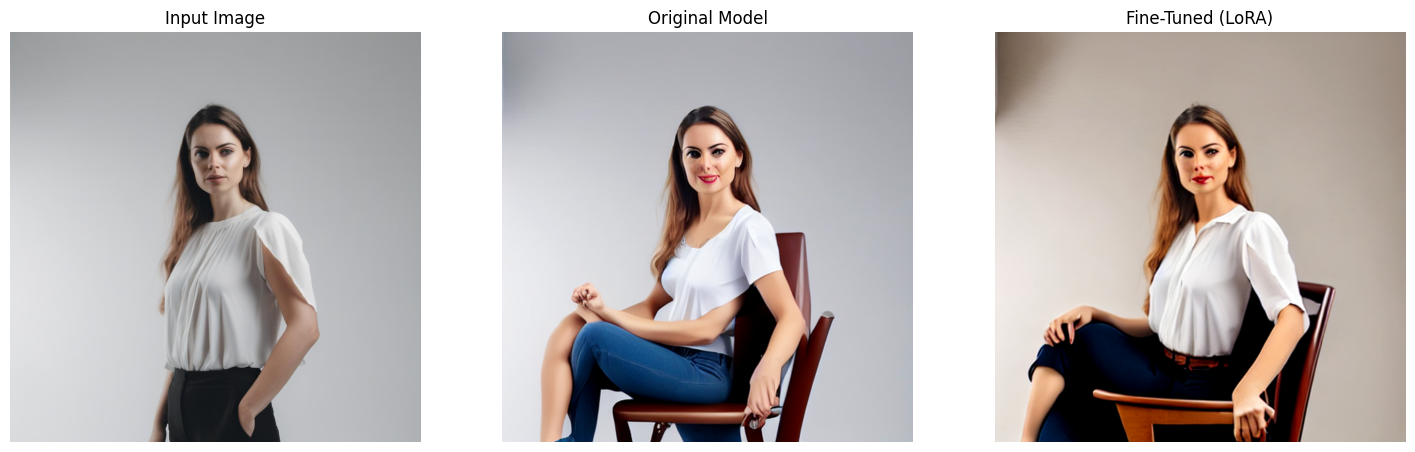

In [ ]:
# ==============================================================================
# 📊 PERBANDINGAN: MODEL ASLI vs FINE-TUNED
# ==============================================================================

# 1. Setup Config untuk Model Asli
config_original = ModelConfig(use_instruct_pix2pix=True, lora_path=None) # Tanpa LoRA
print("\n--- Memuat Model Asli ---")
editor_original = ProfessionalImageEditor(config_original)

# 2. Setup Config untuk Model Fine-Tuned
# Pastikan path ini sesuai dengan folder output training di atas
LORA_PATH = "./lora_instruct_pose_v2/checkpoint-epoch-10"

if os.path.exists(LORA_PATH):
    print("\n--- Memuat Model Fine-Tuned ---")
    config_finetuned = ModelConfig(use_instruct_pix2pix=True, lora_path=LORA_PATH)
    editor_finetuned = ProfessionalImageEditor(config_finetuned)
else:
    print("Path LoRA tidak ditemukan. Jalankan training terlebih dahulu.")
    editor_finetuned = None

# 3. Fungsi Komparasi Visual
def compare_models(image_path, prompt, steps=30):
    if not os.path.exists(image_path):
        print("Image not found")
        return

    original_img = Image.open(image_path).convert("RGB")

    # Edit dengan Model Asli
    print("Generating with Original Model...")
    res_orig, _ = editor_original.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Edit dengan Model Fine-Tuned
    res_ft = None
    if editor_finetuned:
        print("Generating with Fine-Tuned Model...")
        res_ft, _ = editor_finetuned.edit_image(original_img, prompt, num_inference_steps=steps,guidance_scale=7.5, image_guidance_scale=1.5, seed=42, use_controlnet=False)

    # Tampilkan
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(res_orig)
    axes[1].set_title("Original Model")
    axes[1].axis("off")

    if res_ft:
        axes[2].imshow(res_ft)
        axes[2].set_title("Fine-Tuned (LoRA)")
        axes[2].axis("off")
    else:
        axes[2].text(0.5, 0.5, "LoRA Not Loaded", ha='center')

    plt.show()

# CONTOH PENGGUNAAN
# Ganti dengan path gambar tes Anda
TEST_IMAGE = "dataset/images/00027_original.jpg"
TEST_PROMPT = "make her sit on a chair"

compare_models(TEST_IMAGE, TEST_PROMPT)

In [ ]:
!pip install torchmetrics lpips transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics[image] transformers scipy pandas matplotlib seaborn

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from transformers import CLIPProcessor, CLIPModel
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [ ]:
class AdvancedEvaluator:
    def __init__(self, device="cuda"):
        self.device = device
        print("Loading Evaluation Models...")

        # 1. Structural Metrics
        self.psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

        # 2. Perceptual Metric (LPIPS)
        # Net type 'alex' is standard for research papers
        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(device)

        # 3. Semantic Metric (CLIP)
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

        print("Evaluator Ready!")

    def preprocess_image(self, image):
        """Convert PIL to Tensor (0-1 range)"""
        if isinstance(image, Image.Image):
            image = np.array(image).astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
        return image.to(self.device)

    def get_clip_features(self, image, text):
        inputs = self.clip_processor(text=[text], images=image, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
        return outputs.image_embeds, outputs.text_embeds

    def calculate_directional_clip(self, img_orig, img_edit, text_orig, text_edit):
        """
        Mengukur apakah arah perubahan gambar (Delta I) sejajar dengan arah perubahan teks (Delta T).
        Ini metrik paling penting untuk Image Editing.
        """
        # Get embeddings
        inputs_orig = self.clip_processor(text=[text_orig], images=img_orig, return_tensors="pt", padding=True).to(self.device)
        inputs_edit = self.clip_processor(text=[text_edit], images=img_edit, return_tensors="pt", padding=True).to(self.device)

        with torch.no_grad():
            feat_img_orig = self.clip_model.get_image_features(**inputs_orig)
            feat_img_edit = self.clip_model.get_image_features(**inputs_edit)
            feat_text_orig = self.clip_model.get_text_features(**inputs_orig)
            feat_text_edit = self.clip_model.get_text_features(**inputs_edit)

        # Normalize
        feat_img_orig /= feat_img_orig.norm(dim=-1, keepdim=True)
        feat_img_edit /= feat_img_edit.norm(dim=-1, keepdim=True)
        feat_text_orig /= feat_text_orig.norm(dim=-1, keepdim=True)
        feat_text_edit /= feat_text_edit.norm(dim=-1, keepdim=True)

        # Calculate Direction Vectors
        delta_img = feat_img_edit - feat_img_orig
        delta_text = feat_text_edit - feat_text_orig

        # Cosine Similarity of the directions
        similarity = F.cosine_similarity(delta_img, delta_text)
        return similarity.item()

    def evaluate_sample(self, original_image, generated_image, original_prompt, target_prompt):
        """Menghitung SEMUA metrik untuk satu pasang gambar"""
        img_orig_tensor = self.preprocess_image(original_image)
        img_gen_tensor = self.preprocess_image(generated_image)

        # A. Structural (Higher is Better usually, but for edit we want balance)
        psnr_score = self.psnr(img_gen_tensor, img_orig_tensor).item()
        ssim_score = self.ssim(img_gen_tensor, img_orig_tensor).item()

        # B. Perceptual (Lower is Better - measures distortion)
        # Normalize to [-1, 1] for LPIPS
        lpips_score = self.lpips(img_gen_tensor * 2 - 1, img_orig_tensor * 2 - 1).item()

        # C. Alignment (CLIP Score) - Higher is Better
        # Seberapa cocok gambar hasil dengan target prompt
        inputs = self.clip_processor(text=[target_prompt], images=generated_image, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            clip_out = self.clip_model(**inputs)
        clip_score = clip_out.logits_per_image.item() / 100.0 # Standardize to 0-1 approx

        # D. Directional CLIP (Higher is Better)
        dir_clip = self.calculate_directional_clip(original_image, generated_image, original_prompt, target_prompt)

        return {
            "PSNR": psnr_score,
            "SSIM": ssim_score,
            "LPIPS": lpips_score,
            "CLIP_Score": clip_score,
            "Directional_CLIP": dir_clip
        }

    def visualize_radar(self, metrics_avg):
        """Membuat Radar Chart untuk presentasi"""
        categories = list(metrics_avg.keys())
        values = list(metrics_avg.values())

        # Normalisasi data agar grafik bagus (hanya visualisasi)
        # SSIM (0-1), LPIPS (0-1, inverted), Directional (0-1)
        # Kita sesuaikan skala agar 1.0 = Terbaik
        viz_values = []
        for k, v in metrics_avg.items():
            if k == "LPIPS":
                viz_values.append(1.0 - v) # Invert LPIPS because lower is better
            elif k == "PSNR":
                viz_values.append(min(v / 30.0, 1.0)) # Normalize PSNR (assume max 30)
            elif k == "CLIP_Score":
                viz_values.append(min(v / 0.35, 1.0)) # Normalize CLIP (assume max 35 logits)
            else:
                viz_values.append(v)

        # Setup Plot
        N = len(categories)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]
        viz_values += viz_values[:1]

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        ax.plot(angles, viz_values, linewidth=2, linestyle='solid', color='blue')
        ax.fill(angles, viz_values, 'b', alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        plt.title("Model Performance Overview", y=1.1)
        plt.show()

⚙️ Loading Evaluation Models...
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 235MB/s]


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ Evaluator Ready!
📂 Memuat dataset dari: ./dataset/metadata.jsonl
🚀 Mulai generating 5 sampel test...


Processing:   0%|          | 0/5 [00:00<?, ?it/s]

🎨 Editing: 'make the person sit down'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.97s
🎨 Editing: 'make the character sit'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.73s
🎨 Editing: 'make the person sit down'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.62s
🎨 Editing: 'sit on a bench'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.45s
🎨 Editing: 'sit on a chair'
   Steps: 30, Guidance: 7.5


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Complete in 5.37s

🚀 Evaluating 5 samples...


  0%|          | 0/5 [00:00<?, ?it/s]


=== 📊 Detailed Metrics Report ===
PSNR                18.072037
SSIM                 0.772971
LPIPS                0.316340
CLIP_Score           0.230535
Directional_CLIP     0.049841
dtype: float64


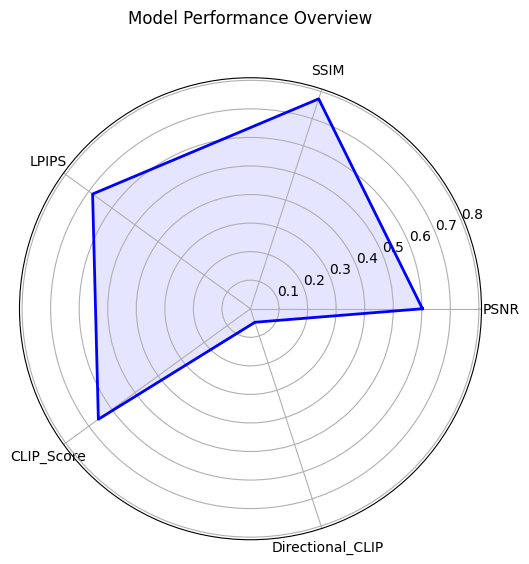

In [ ]:
# 1. Inisialisasi
evaluator = AdvancedEvaluator()

# 2. Siapkan Data Test (Contoh List)
# Format: {'orig': PIL_Image, 'gen': PIL_Image, 'prompt_orig': str, 'prompt_target': str}
test_samples = []

# 1. Pastikan Editor sudah siap
# (Code ini mengasumsikan Anda sudah menjalankan cell class ProfessionalImageEditor sebelumnya)
if 'editor' not in locals():
    print("Inisialisasi Editor baru...")
    config_finetuned = ModelConfig(use_instruct_pix2pix=True, lora_path=LORA_PATH)
    editor_finetuned = ProfessionalImageEditor(config_finetuned)

test_samples = []

METADATA_PATH = "./dataset/metadata.jsonl" # Pastikan path ini sesuai dengan Cell 12
DATASET_DIR = "./dataset"

if os.path.exists(METADATA_PATH):
    print(f" Memuat dataset dari: {METADATA_PATH}")

    with open(METADATA_PATH, 'r') as f:
        # Baca semua baris metadata
        lines = f.readlines()

    # Ambil 5 sampel pertama untuk testing
    # Ganti [:5] dengan jumlah yang Anda mau, misal [:10]
    samples_to_test = lines[:5]

    print(f"Mulai generating {len(samples_to_test)} sampel test...")

    for line in tqdm(samples_to_test, desc="Processing"):
        entry = json.loads(line)

        # Load Original Image
        img_path = os.path.join(DATASET_DIR, entry['original_image'])
        if not os.path.exists(img_path):
            print(f"Gambar tidak ditemukan: {img_path}")
            continue

        original_image = Image.open(img_path).convert("RGB")
        target_prompt = entry['edit_prompt']

        # Jalankan Editor
        # Pastikan 'editor' (baik base atau fine-tuned) sudah di-init sebelumnya
        result_image, _ = editor_finetuned.edit_image(
            image=original_image,
            prompt=target_prompt,
            num_inference_steps=30,
            guidance_scale=7.5,
            image_guidance_scale=1.5,
            seed=42,
            use_controlnet=False # Added this line to explicitly disable ControlNet for evaluation
        )

        test_samples.append({
            'orig': original_image,
            'gen': result_image,
            'prompt_orig': "original image", # Default karena metadata tidak simpan caption asli
            'prompt_target': target_prompt
        })
else:
    print("Metadata dataset tidak ditemukan! Pastikan Anda sudah menjalankan Cell Generate Dataset.")


# 3. Jalankan Evaluasi
results = []
print(f"\n Evaluating {len(test_samples)} samples...")

for sample in tqdm(test_samples):
    metrics = evaluator.evaluate_sample(
        sample['orig'],
        sample['gen'],
        sample['prompt_orig'],
        sample['prompt_target']
    )
    results.append(metrics)

# 4. Tampilkan Hasil Rata-rata
df_results = pd.DataFrame(results)
print("\n=== Detailed Metrics Report ===")
print(df_results.mean())

# 5. Buat Radar Chart untuk PPT
evaluator.visualize_radar(df_results.mean().to_dict())